## Error Detection

### Importing

In [284]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib as mpl

plt.style.use("fivethirtyeight")

### Data File

In [201]:
df = pl.read_csv(
    "sept_17_21h44_first.csv",
    schema_overrides={
        "trigger_id": pl.UInt16,
        "trigger_clk": pl.UInt64,
        "integer_data": pl.UInt32,
        "idk": pl.UInt32,
        "sensor_1-2": pl.Utf8,
        "sensor_3-4": pl.Utf8,
        "sensor_5-6": pl.Utf8,
        "internal_trigger": pl.Boolean,
        "veto_in": pl.Boolean
    }
)

binary_cols = ["sensor_1-2", "sensor_3-4", "sensor_5-6"]

df = df.with_columns([
    pl.col(col)
    .map_elements(lambda b: int(b, 2) if b is not None else None, return_dtype=pl.UInt8)
    .alias(col)
    for col in binary_cols
])

df = df.drop("integer_data").drop("idk")
print(df)

shape: (15_527, 7)
┌────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────┬─────────┐
│ trigger_id ┆ trigger_clk ┆ sensor_1-2 ┆ sensor_3-4 ┆ sensor_5-6 ┆ internal_trigger ┆ veto_in │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---              ┆ ---     │
│ u16        ┆ u64         ┆ u8         ┆ u8         ┆ u8         ┆ bool             ┆ bool    │
╞════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════════╪═════════╡
│ 0          ┆ 1882168984  ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 1882176984  ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 1072996353  ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 1073038198  ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 1073168771  ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ …        

### Time Conversion

In [202]:
df = df.with_columns(
    (pl.col("trigger_clk") / 40000000).alias("trigger_clk")
)
print(df)

shape: (15_527, 7)
┌────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────┬─────────┐
│ trigger_id ┆ trigger_clk ┆ sensor_1-2 ┆ sensor_3-4 ┆ sensor_5-6 ┆ internal_trigger ┆ veto_in │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---              ┆ ---     │
│ u16        ┆ f64         ┆ u8         ┆ u8         ┆ u8         ┆ bool             ┆ bool    │
╞════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════════╪═════════╡
│ 0          ┆ 47.054225   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 47.054425   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 26.824909   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 26.825955   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 26.829219   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ …        

#### Printing DataFrame

In [203]:
print(df[12:22])

shape: (10, 7)
┌────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────┬─────────┐
│ trigger_id ┆ trigger_clk ┆ sensor_1-2 ┆ sensor_3-4 ┆ sensor_5-6 ┆ internal_trigger ┆ veto_in │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---              ┆ ---     │
│ u16        ┆ f64         ┆ u8         ┆ u8         ┆ u8         ┆ bool             ┆ bool    │
╞════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════════╪═════════╡
│ 0          ┆ 27.300617   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 27.303773   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 27.304063   ┆ 255        ┆ 255        ┆ 1          ┆ false            ┆ true    │
│ 0          ┆ 27.461707   ┆ 255        ┆ 255        ┆ 0          ┆ false            ┆ false   │
│ 0          ┆ 27.475376   ┆ 255        ┆ 255        ┆ 2          ┆ false            ┆ true    │
│ 0          ┆ 

### Trigger Data Errors

In [204]:
def extract_chunks(df, col_name, chunk_start_idx):
    df = df.with_columns(
        pl.col(col_name)
        .cast(pl.UInt8)
        .map_elements(lambda x: format(x, '08b'), return_dtype=pl.String)
        .alias(f"{col_name}_binary")
    )
    df = df.with_columns([
        pl.col(f"{col_name}_binary")
        .str.slice(i * 2, 2)
        .map_elements(lambda b: int(b, 2), return_dtype=pl.UInt8)
        .alias(f"chunk_{chunk_start_idx + i}")
        for i in range(4)
    ])
    df = df.drop(f"{col_name}_binary")
    return df

df = extract_chunks(df, "sensor_1-2", 0)
df = extract_chunks(df, "sensor_3-4", 4)
df = extract_chunks(df, "sensor_5-6", 8)

chunk_df = df.select([f"chunk_{i}" for i in range(12)])

df = df.drop([f"chunk_{i}" for i in range(12)])
print(chunk_df)

shape: (15_527, 12)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬──────────┬──────────┐
│ chunk_0 ┆ chunk_1 ┆ chunk_2 ┆ chunk_3 ┆ … ┆ chunk_8 ┆ chunk_9 ┆ chunk_10 ┆ chunk_11 │
│ ---     ┆ ---     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ u8      ┆ u8      ┆ u8      ┆ u8      ┆   ┆ u8      ┆ u8      ┆ u8       ┆ u8       │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪══════════╪══════════╡
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …        ┆ …        │
│ 3       ┆ 

#### Printing DataFrames

In [205]:
s12_df = chunk_df.select([f"chunk_{i}" for i in range(4)])
print(s12_df)

shape: (15_527, 4)
┌─────────┬─────────┬─────────┬─────────┐
│ chunk_0 ┆ chunk_1 ┆ chunk_2 ┆ chunk_3 │
│ ---     ┆ ---     ┆ ---     ┆ ---     │
│ u8      ┆ u8      ┆ u8      ┆ u8      │
╞═════════╪═════════╪═════════╪═════════╡
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ …       ┆ …       ┆ …       ┆ …       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
└─────────┴─────────┴─────────┴─────────┘


In [206]:
s34_df = chunk_df.select([f"chunk_{i}" for i in range(4,8)])
print(s34_df)

shape: (15_527, 4)
┌─────────┬─────────┬─────────┬─────────┐
│ chunk_4 ┆ chunk_5 ┆ chunk_6 ┆ chunk_7 │
│ ---     ┆ ---     ┆ ---     ┆ ---     │
│ u8      ┆ u8      ┆ u8      ┆ u8      │
╞═════════╪═════════╪═════════╪═════════╡
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ …       ┆ …       ┆ …       ┆ …       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
│ 3       ┆ 3       ┆ 3       ┆ 3       │
└─────────┴─────────┴─────────┴─────────┘


In [207]:
s56_df = chunk_df.select([f"chunk_{i}" for i in range(8,12)])
print(s56_df)

shape: (15_527, 4)
┌─────────┬─────────┬──────────┬──────────┐
│ chunk_8 ┆ chunk_9 ┆ chunk_10 ┆ chunk_11 │
│ ---     ┆ ---     ┆ ---      ┆ ---      │
│ u8      ┆ u8      ┆ u8       ┆ u8       │
╞═════════╪═════════╪══════════╪══════════╡
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ …       ┆ …       ┆ …        ┆ …        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 0       ┆ 2       ┆ 0        ┆ 0        │
│ 0       ┆ 0       ┆ 0        ┆ 0        │
└─────────┴─────────┴──────────┴──────────┘


### Veto In Errors

In [208]:
vi_df = df.filter(pl.col("veto_in") == True)

#### Printing DataFrames

In [209]:
print(vi_df)

shape: (1_237, 7)
┌────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────┬─────────┐
│ trigger_id ┆ trigger_clk ┆ sensor_1-2 ┆ sensor_3-4 ┆ sensor_5-6 ┆ internal_trigger ┆ veto_in │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---              ┆ ---     │
│ u16        ┆ f64         ┆ u8         ┆ u8         ┆ u8         ┆ bool             ┆ bool    │
╞════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════════╪═════════╡
│ 0          ┆ 27.304063   ┆ 255        ┆ 255        ┆ 1          ┆ false            ┆ true    │
│ 0          ┆ 27.475376   ┆ 255        ┆ 255        ┆ 2          ┆ false            ┆ true    │
│ 0          ┆ 27.63347    ┆ 255        ┆ 255        ┆ 128        ┆ false            ┆ true    │
│ 0          ┆ 27.671425   ┆ 255        ┆ 255        ┆ 128        ┆ false            ┆ true    │
│ 0          ┆ 28.262075   ┆ 255        ┆ 255        ┆ 32         ┆ false            ┆ true    │
│ …         

### Only Seconds (From Clock Cycle)

In [232]:
clk_df = vi_df.select(pl.exclude("trigger_id", "sensor_1-2", "sensor_3-4", "sensor_5-6", "internal_trigger", "veto_in"))

### Printing DataFrame

In [233]:
print(clk_df)

shape: (1_237, 1)
┌─────────────┐
│ trigger_clk │
│ ---         │
│ f64         │
╞═════════════╡
│ 27.304063   │
│ 27.475376   │
│ 27.63347    │
│ 27.671425   │
│ 28.262075   │
│ …           │
│ 757.795242  │
│ 758.663021  │
│ 758.746499  │
│ 759.062116  │
│ 759.392468  │
└─────────────┘


### Internal Trigger Errors

In [210]:
it_df = df.filter(pl.col("internal_trigger") == True)

#### Printing DataFrames

In [211]:
print(it_df)

shape: (0, 7)
┌────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────┬─────────┐
│ trigger_id ┆ trigger_clk ┆ sensor_1-2 ┆ sensor_3-4 ┆ sensor_5-6 ┆ internal_trigger ┆ veto_in │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---              ┆ ---     │
│ u16        ┆ f64         ┆ u8         ┆ u8         ┆ u8         ┆ bool             ┆ bool    │
╞════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════════╪═════════╡
└────────────┴─────────────┴────────────┴────────────┴────────────┴──────────────────┴─────────┘


## Plotting

### Heat Map (Hit Count)

In [288]:
hm_df = chunk_df.select([f"chunk_{i}" for i in range(12)])

#print(hm_df)
#print(hm_df.to_numpy())

channel = ["chunk_1", "chunk_2", "chunk_3", "chunk_4", "chunk_5", "chunk_6", "chunk_7",
           "chunk_8", "chunk_9", "chunk_10", "chunk_11"]

customScale = [(0,"red"),(0.333,"rgb(235,110,15)"),(0.66,"rgb(210,0,110)"),(1,"rgb(145,125,185)")]
# limits to 10000 data points because won't render with all -> not sure (in case add: [:10000] after numpy())
fig = px.imshow(hm_df.to_numpy().T,aspect='auto', labels=dict(y="Channels",
        x="Hit Count", title="SiPM Activation Type over Cycles", color="Activation Type"),
                y=["0 & 1","2 & 3", "4 & 5", "6 & 7", "8 & 9","10 & 11", "12 & 13", "14 & 15",
            "16 & 17", "18 & 19", "20 & 21", "22 & 23"], color_continuous_scale="turbo") #or hsv (for fun)

fig.update_xaxes(side="bottom")

fig.show()

### Heat Map (Time)

In [ ]:
hm_df = chunk_df.select([f"chunk_{i}" for i in range(12)])

vegetables = ["0 & 1","2 & 3", "4 & 5", "6 & 7", "8 & 9","10 & 11", "12 & 13", "14 & 15",
            "16 & 17", "18 & 19", "20 & 21", "22 & 23"]

farmers = clk_df.to_numpy()
channel_type = hm_df.to_numpy()

""" time = np.array(clk_df)
channel_type = np.array(hm_df)

print(time)
print(channel_type)


fig, ax = plt.subplots()
im = ax.imshow(channel_type)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(time)), labels=time,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(channels)), labels=channels) """

""" ax.set_title("Channel Activation over Time")
#fig.tight_layout()
plt.show()  """


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    im = ax.imshow(data, **kwargs) # Plot the heatmap

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw) # Create colorbar
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

"""     ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor") # Show all ticks and label them with the respective list entries.
    ax.set_yticks(range(data.shape[0]), labels=row_labels) """

"""     ax.spines[:].set_visible(False)  # Turn spines off and create white grid.
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False) """

#return im, cbar


fig, ax = plt.subplots()

im, cbar = heatmap(channel_type, vegetables, farmers, ax=ax,
                   cmap="turbo", cbarlabel="Activation Type")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

SyntaxError: 'return' outside function (3482132276.py, line 53)

### Gaussian Distribution

In [ ]:
## SEE EVAN'S CODE ##

### Bar Graph I (irrelevant)

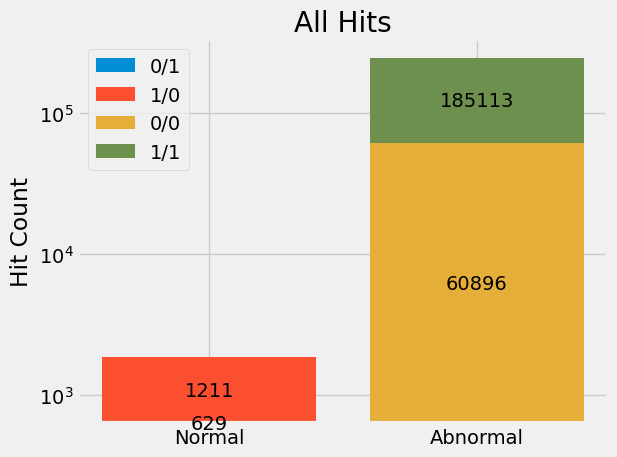

In [ ]:
hm_df = chunk_df.select([f"chunk_{i}" for i in range(12)])
#print(hm_df)

value_counts = hm_df.unpivot().get_column("value").value_counts().to_numpy()

t0x, t0y = np.where(value_counts==0)
t1x, t1y = np.where(value_counts==1)
t2x, t2y = np.where(value_counts==2)
t3x, t3y = np.where(value_counts==3)
#print(f'zero is {array[t0x, t0y+1]}')

#c = value_counts.transpose()
#print(14, c)
#
##print(zero_value, one_value, two_value, three_value)
#print(value_counts)
#print(0, value_counts.row(1), 1, value_counts.row(3), 2, value_counts.row(2), 3, value_counts.row(0),)
#
#zero = value_counts.filter(pl.col('value')=='0')
#print(f'zero is {zero}')


hit_events = {
    "nonevent" : 0,
    "0/0" : value_counts[t0x, t0y+1][0],
    "0/1" : value_counts[t1x, t1y+1][0],
    "1/0" : value_counts[t2x, t2y+1][0],
    "1/1" : value_counts[t3x, t3y+1][0],
}
groups = {
    "Normal"   : ["nonevent", "0/1", "1/0"],
    "Abnormal" : ["nonevent", "0/0", "1/1"],
}

width = 0.5

fig, ax = plt.subplots()


for group in groups:
    for idx, subtype in enumerate(groups[group]):
        if idx==0:
            continue

        top    = hit_events[groups[group][idx]]
        bottom = hit_events[groups[group][idx-1]]
        height = top+bottom
        #print(f'good to here', group, height, bottom, groups[group][idx], top)
        this_bar = ax.bar(x=group, height=height, bottom=bottom, label=groups[group][idx])
        ax.bar_label(this_bar, label_type='center')

#for teaching purposes (pls ignore)
""" for group in groups:
    for idx, subtype in enumerate(groups[group]):
        if idx==0:
            continue

        box2 = groups[group]

        current_value = box2[idx]
        previous_value = box2[idx-1]

        top    = hit_events[current_value]
        bottom = hit_events[previous_value]
        this_bar = ax.bar(x=group, height=top-bottom, bottom=bottom, label=current_value)
        ax.bar_label(this_bar, label_type='center') """ 

ax.legend()

ax.set_title("All Hits")
ax.set_ylabel("Hit Count")
plt.gca().set_yscale("log")
plt.tight_layout()
plt.show()


### Bar Graph II (irrelevant)

[[     3 124217]
 [     1    629]
 [     0  60896]
 [     2    582]]


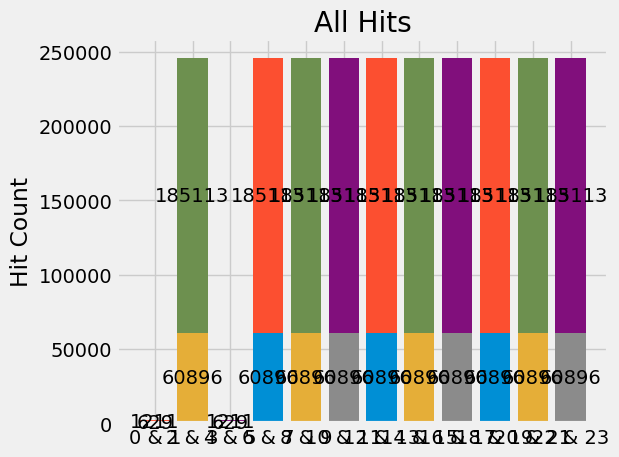

In [ ]:
hm_df = chunk_df.select([f"chunk_{i}" for i in range(12)])
hm_df.select("chunk_0")

value_counts = hm_df.unpivot().get_column("value").value_counts().to_numpy()
print(value_counts)

t0x, t0y = np.where(value_counts==0)
t1x, t1y = np.where(value_counts==1)
t2x, t2y = np.where(value_counts==2)
t3x, t3y = np.where(value_counts==3)

hit_types = {
    "nonevent" : 0,
    "0/0" : value_counts[t0x, t0y+1][0],
    "0/1" : value_counts[t1x, t1y+1][0],
    "1/0" : value_counts[t2x, t2y+1][0],
    "1/1" : value_counts[t3x, t3y+1][0],
}

channels = {
    "0 & 1"   : ["nonevent", "0/1", "1/0"],
    "2 & 3" : ["nonevent", "0/0", "1/1"],
    "4 & 5"   : ["nonevent", "0/1", "1/0"],
    "6 & 7" : ["nonevent", "0/0", "1/1"],
    "8 & 9" : ["nonevent", "0/0", "1/1"],
    "10 & 11" : ["nonevent", "0/0", "1/1"],
    "12 & 13" : ["nonevent", "0/0", "1/1"],
    "14 & 15" : ["nonevent", "0/0", "1/1"],
    "16 & 17" : ["nonevent", "0/0", "1/1"],
    "18 & 19" : ["nonevent", "0/0", "1/1"],
    "20 & 21" : ["nonevent", "0/0", "1/1"],
    "22 & 23" : ["nonevent", "0/0", "1/1"]
    }

width = 0.5

fig, ax = plt.subplots()

for channel in channels.keys():
    for idx, subtype in enumerate(channels[channel]):
        if idx==0:
            continue

        top    = hit_types[channels[channel][idx]]
        bottom = hit_types[channels[channel][idx-1]]
        height = top+bottom
        this_bar = ax.bar(x=channel, height=height, bottom=bottom, label=channels[channel][idx])
        ax.bar_label(this_bar, label_type='center')

#ax.legend()

ax.set_title("All Hits")
ax.set_ylabel("Hit Count")
#plt.gca().set_yscale("log")
plt.tight_layout()
plt.show()


shape: (15_527, 12)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬──────────┬──────────┐
│ chunk_0 ┆ chunk_1 ┆ chunk_2 ┆ chunk_3 ┆ … ┆ chunk_8 ┆ chunk_9 ┆ chunk_10 ┆ chunk_11 │
│ ---     ┆ ---     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ u8      ┆ u8      ┆ u8      ┆ u8      ┆   ┆ u8      ┆ u8      ┆ u8       ┆ u8       │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪══════════╪══════════╡
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ 3       ┆ 3       ┆ 3       ┆ 3       ┆ … ┆ 0       ┆ 0       ┆ 0        ┆ 0        │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …        ┆ …        │
│ 3       ┆ 

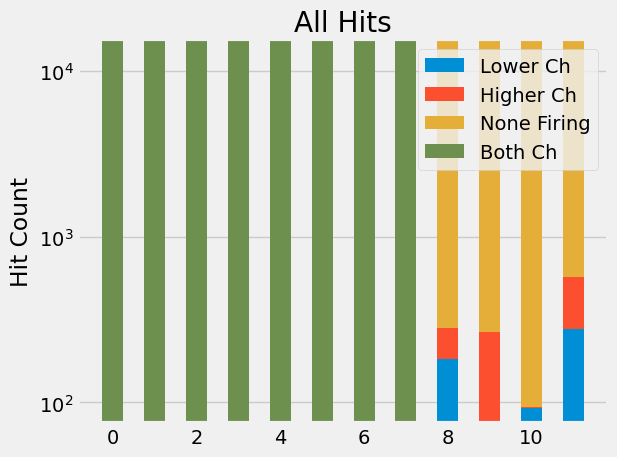

In [ ]:
hm_df = chunk_df.select([f"chunk_{i}" for i in range(12)])
print(hm_df)
Num0 = []
Num1 = []
Num2 = []
Num3 = []
for chunkID in range(12):
    print(chunkID)
    #print(hm_df.select("chunk_"+str(chunkID)))
    value = hm_df.select("chunk_"+str(chunkID)).unpivot().get_column("value").to_numpy()
    print(hm_df.select("chunk_"+str(chunkID)).unpivot().get_column("value").to_numpy())

    Binary0 =  np.sum(value==0)
    Binary1 = np.sum(value==1)
    Binary2 =  np.sum(value==2)
    Binary3 =  np.sum(value==3)

    #Binary1 =  value_counts[t1x, t1y+1][0]
    #Binary2 =  value_counts[t2x, t2y+1][0]
    #Binary3 =  value_counts[t3x, t3y+1][0]

    Num0.append(Binary0)
    Num1.append(Binary1)
    Num2.append(Binary2)
    Num3.append(Binary3)
    

data  = {
    "Lower Ch" :np.array(Num1),
    "Higher Ch" : np.array(Num2),
    "None Firing" : np.array(Num0),
    "Both Ch" : np.array(Num3),
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(12)
chunks = np.arange(0,12,1)
for label  in data.keys():
    print(data[label])
    p = ax.bar(chunks, data[label], width, label=label, bottom=bottom)
    bottom +=  data[label]
plt.gca().set_yscale("log")

ax.legend()

ax.set_title("All Hits")
ax.set_ylabel("Hit Count")

plt.tight_layout()

In [ ]:
for chunkID in range(12):
    print(chunkID)

0
1
2
3
4
5
6
7
8
9
10
11
